### TODO
* copy in other file
* find unused code
* doublecheck zeropoints
* doublecheck catalogue
* check folder - a temp data folder
* catalogue referencing later is not with variablized
* update planck cosmology
* correct interpolation method for errorbars
* do a $\Chi^2$ histogra, to the right of the spectras
* Add that red line of best guess to plot

In [2]:
catalogue = "gds/jades/phot/hlsp_jades_jwst_nircam_goods-s-deep_photometry_v1.0_catalog_large_withSpec.fits"
cat_out_name = "gds_jwst_nircam_large_withSpec"
spec_dir = "gds/jades/spec/hlsp_jades_jwst_nirspec_goods-s-deephst_clear-prism_v1.0"
zmin = 1.0
rebinWidth = 0.05
# template names and paths

ftempl_labeldict = {#! use ; to indicate modifications
    'fsps_45k;linearcomb': "F45k;LC",
    'fsps_45k;0.3removed': "F45k;0.3r",
    'EMLines;linearcomb': "EMLi;LC",
    'EMextreme': "EMEx",
    'EMlines': "EMLi",
    'fsps_45k': "F45k",
    'fsps_60k': "F60k",
    'carnall_sfhz_13': "CASFH",
    'corr_sfhz_13': "COSFH",
    'blue_sfhz_13': "BLSFH",
    #"EAZL",
    'eazy_v1.3.spectra': "EAZ3",
    #"BR07",
    #"PEG",
    #"PEG13",
    #"CWWK"
}

In [3]:
##################### READ IN TEMPLATES #####################
import os
ftempl_strs = []
ftempl_labels = []
for f in os.listdir("templates2test"):
    if f.endswith(".param"):
        templ_str = f.split(".param")[0]
        ftempl_strs.append(templ_str)
        try:
            ftempl_labels.append(ftempl_labeldict[templ_str])
        except KeyError:
            raise KeyError("No label for template: ", templ_str)
    else: continue
    print("Found template: ", templ_str)
    print("Label: ", ftempl_labeldict[templ_str])
    print("")

Found template:  fsps_45k;0.3removed
Label:  F45k;0.3r

Found template:  corr_sfhz_13
Label:  COSFH

Found template:  fsps_60k
Label:  F60k

Found template:  EMextreme
Label:  EMEx

Found template:  blue_sfhz_13
Label:  BLSFH

Found template:  carnall_sfhz_13
Label:  CASFH

Found template:  eazy_v1.3.spectra
Label:  EAZ3

Found template:  EMlines
Label:  EMLi

Found template:  EMLines;linearcomb
Label:  EMLi;LC

Found template:  fsps_45k
Label:  F45k

Found template:  fsps_45k;linearcomb
Label:  F45k;LC



In [4]:
import eazy
from eazy import filters, utils

#import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import numpy as np
import pandas as pd

#import pandas as pd
import time
import os
from math import ceil#, floor
from copy import deepcopy as copy
import shutil
from astropy import units as u
from astropy.cosmology import Planck18
from astropy.io import fits
from astropy.table import Table, join#, hstack
from IPython.utils import io
from tqdm import tqdm
from numba import jit
#from astropy.visualization import ZScaleInterval as zs
#from astroquery.mast import Observations as obs
#from IPython.utils import io
#from matplotlib.transforms import Affine2D
#from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import eazy_routines as ez
import helper_module as hmod

if not os.path.exists('templates'):
    eazy.symlink_eazy_inputs()
    for f in os.listdir("templates2test"):
        shutil.copy("templates2test/"+f, "templates/"+f, follow_symlinks=True, exist_ok=True)


cosmo = Planck18
del Planck18

plt.style.use('seaborn-v0_8-colorblind')

if "temp" not in os.listdir():
    os.mkdir("temp")

In [5]:
# log all camera filters
flt = eazy.filters.FilterFile()

filts_nircam = {
    'F090W': 363,
    'F115W': 364,
    'F150W': 365,
    'F182M': 370,
    'F200W': 366,
    'F210M': 371,
    'F277W': 375,
    'F335M': 381,
    'F356W': 376,
    'F410M': 383,
    'F430M': 384,
    'F444W': 358,
    'F460M': 385,
    'F480M': 386
}

filts_HST = {
    'F105W': 202,
    'F125W': 203,
    'F140W': 204,
    'F160W': 205,
    'F435W': 233,
    'F606W': 214,
    'F775W': 216,
    'F814W': 239,
    'F850LP': 240        
}

filts_wavelengths = {#!actually check
}
res = filters.FilterFile('FILTER.RES.latest')
for f in res.filters:
    for filt in filts_nircam | filts_HST:
        if filt.lower() in f.name:
            filts_wavelengths[filt] = {
                'mean': f.pivot,
                'width': f.rectwidth
                }
            break

filts = {**filts_nircam, **filts_HST}
del filts_HST, filts_nircam

mw_reddening = ez.get_atten_dict(filts)#!is used?

# get zeropoints
zps = [1.0]*len(filts)#!should be evaluated if this is correct

In [6]:
#=== load data
#inname = "hlsp_jades_jwst_nircam_goods-s-deep_photometry_v1.0_catalog.fits"
inname = catalogue.split('/')[-1]
inpath = os.path.join(os.getenv('astrodata'), catalogue)

# print the meta info
with fits.open(inpath) as hdul:
    print(hdul.info())

# load photometry table
tab = Table.read(inpath, hdu=6)
tab_redshifts = Table.read(inpath, hdu=9)

#=== make EAZY table

# load fluxes
# CIRC1: 0.10 arcsec aperture (see README)
ext = '_CIRC1'
cols_dummy = hmod.get_matches(ext, tab.columns, exclude='_ei')
cols_f = np.sort(hmod.get_matches(ext, cols_dummy, exclude='_e'))
cols_fe = np.sort(hmod.get_matches('_e', cols_dummy))
cols_fluxes = list(np.vstack([cols_f, cols_fe]).T.flatten())
cols = list(np.insert(cols_fluxes, 0, ['ID', 'RA', 'DEC', 'z_spec']))
del cols_dummy

tab = join(tab, tab_redshifts['ID', 'z_spec'], join_type='inner', keys='ID')
tab_out = tab[cols]

# convert from nJy to uJy
# and apply MW reddening
keys = np.array(list(mw_reddening.keys()))
for c in cols_fluxes:
    tab_out[c].unit = u.nJy
    tab_out[c] = tab_out[c].to(u.uJy)
    
    # apply MW reddening
    matches = hmod.get_matches(keys, c, get_idxs=True)
    key = keys[np.int32(matches[:,0])][0]
    tab_out[c] *= mw_reddening[key]
del c, keys, key, matches

# redshift limit

for i in range(len(tab_out)):
    if tab_out['z_spec'][i] < zmin:
        tab_out['z_spec'][i] = -1.0
    
# rename columns
for c in cols_f:
    cnew = c.replace(ext, '_flux')
    tab_out.rename_column(c, cnew)
del c, cnew

for c in cols_fe:
    cnew = c.replace(ext+'_e', '_err')
    tab_out.rename_column(c, cnew)
del c, cnew

#=== apply MW reddening
#atten_dict = ez.get_atten_dict(filts_eazyres, filts_str)
#degr_image_sig *= atten_dict[filt] / 100. # uJy

# save EAZY table
tab_out.write(f'temp/{cat_out_name}.fits', format='fits', overwrite=True)
del tab_out, tab, tab_redshifts

Filename: /home/ubuntu-compute/Desktop/astrodata/gds/jades/phot/hlsp_jades_jwst_nircam_goods-s-deep_photometry_v1.0_catalog_large_withSpec.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      13   ()      
  1  FILTERS       1 BinTableHDU     33   23R x 12C   [6A, E, E, E, E, E, E, E, E, E, E, E]   
  2  FLAG          1 BinTableHDU    161   1429R x 75C   [J, D, D, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E]   
  3  SIZE          1 BinTableHDU    100   1429R x 43C   [J, D, D, E, D, D, D, D, J, J, J, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   
  4  CIRC          1 BinTableHDU    856   1429R x 423C   [J, D, D, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E,

None


In [7]:
runTime = int(time.time())

In [8]:
#=== set up paths for eazy

# catalog paths
cat_path = f'temp/{cat_out_name}.fits'
keys_id = ['ID id', 'RA ra', 'DEC dec', 'z_spec z_spec']



templ_paths = [f"templates/{e}.param" for e in ftempl_strs]
out_names = [f for f in ftempl_strs]
out_paths = [f"eazy-output/{f}_{runTime}" for f in out_names]
#paths = np.array([templ_paths, out_paths]).T

In [9]:
##################### PHOTOZ OBJECT CONFIG #####################
paramsSet = []
for tpath, opath, oname in zip(templ_paths, out_paths, out_names):
    params = {
        "cat_path": cat_path,
        "templ_path": tpath,
        "out_path": opath,
        "FIX_ZSPEC": 'n',
        "USE_ZSPEC_FOR_REST": 'n',
        "Z_MAX": 12.0,
        "H0": cosmo.H0,
        "OMEGA_M": cosmo.Om0,
        "OMEGA_L": cosmo.Ode0,
        "CATALOG_FORMAT": 'fits',
        'VERBOSE': 'y'}
    paramsSet.append(params)
paramsDict = dict(zip(out_names, paramsSet))
del tpath, opath, oname, params, paramsSet

In [10]:
##################### RUN EAZY #####################
if True: raise UserWarning("This will run EAZY. Set to False to avoid this.")
# iterate over tempalte sets
photZs = []
for tpath, opath, oname in zip(templ_paths, out_paths, out_names):

    params = paramsDict[oname]
    
    # write eazy config files
    filt_num, fnames = ez.write_config(f'{cat_out_name}_{oname}', filts, zps, keys_id,
                                       out_path=opath)

    # run eazy
    #idx = np.array([0])
    idx = None
    #zout, hdu = ez.run_eazy(params, fnames, n_proc=-1, idx=idx)
    #from eazy import photoz
    #from eazy import templates
    #from eazy import filters
    #from eazy import utils
    #photZ = photoz.PhotoZ(param_file=tpath, translate_file='gds_jades_eazy.zphot.translate', zeropoint_file=None,
    #                        params=params)
    #photZ.fit_parallel(n_proc=-1, idx=idx)
    pz = ez.eazy_init_photoz(params,
                                ftran=fnames['ftran'],
                                fzp=fnames['fzp'])
    pz.fit_catalog(idx=idx, n_proc=-1, verbose=True, get_best_fit=True)
    tbl, hdu = pz.standard_output(#UBVJ=None,#percentile_limits=[],#!some bug bug preventing me from removing UBVJ,percentile_limits
                                        extra_rf_filters=filt_num,#!set pad_width=0 and max_err=0 maybe??
                                        save_fits=2)
    tbl.write(f'{opath}/out_eazy.fits', format='fits', overwrite=True)
                                  
    #break
    #print(chi2_fit)
    #print(fit_coeffs)
    #zout, __ = ez.run_eazy(params, fnames, n_proc=-1, idx=idx)
    #photZs.append(zout)
    del idx, params, filt_num, fnames, tpath, opath, oname

UserWarning: This will run EAZY. Set to False to avoid this.

In [11]:
#find latest runTime in folder:
runtimeNum = -2
runTimes = np.sort([int(f.split('_')[-1]) for f in os.listdir('eazy-output') if f != '.gitignore'])
runTimes = np.unique(runTimes)
runTime = int(runTimes[runtimeNum])
outpaths_f = 'eazy-output/{ftempl}_{runTime}/' + cat_out_name + '.zout.fits'
print("Picking runTime:", runTime)
del runTimes, runtimeNum
out_paths = [os.path.dirname(outpaths_f.format(ftempl=f, runTime=runTime)) for f in ftempl_strs]

Picking runTime: 1697460987


In [12]:
maxLen = 100
out_paths = out_paths[:maxLen]
ftempl_strs = ftempl_strs[:maxLen]
out_names = out_names[:maxLen]
templ_paths = templ_paths[:maxLen]
ftempl_labels = ftempl_labels[:maxLen]

In [13]:
##################### EAZY PHOTZ OBJECT DATA #####################
#pack all usefull data
#if input("Press Enter to continue...") != "": raise UserWarning("This will load the photZ objects...")
if False: raise UserWarning("This will run EAZY. Set to False to avoid this.")
photZs = {}

photZs['output_df'] = {}
for tpath, opath, oname, ftempl in zip(templ_paths, out_paths, out_names, ftempl_strs):
    tbl = Table.read(opath + '/' + cat_out_name + '.zout.fits')
    restPhot = {key: tbl[key] for key in tbl.keys() if key.startswith('rest')}
    photVals = {int(key.split('rest')[-1]): tbl[key] for key in tbl.keys() if key.split('rest')[-1].isnumeric()}
    photErrs = {int(key.split('rest')[-1].split("_")[0]): tbl[key] for key in tbl.keys() if key.split('rest')[-1].split("_")[0].isnumeric() and key.endswith('err')}
    usefullColls = {
        'ID': tbl['id'],
        'z_spec': tbl['z_spec'],
        'z_phot': tbl['z_phot'],
        'z_phot_chi2': tbl['z_phot_chi2'],
        'z_phot_risk': tbl['z_phot_risk']
    }
    for filt in photVals.keys():
        usefullColls[f'{filt}_val'] = photVals[filt]
        usefullColls[f'{filt}_err'] = photErrs[filt]
    photZs['output_df'][ftempl] = Table(
        data = [d for d in usefullColls.values()],
        names = [d for d in usefullColls.keys()]
    )

photZs['output_pz'] = {}
for tpath, opath, oname, ftempl in tqdm(zip(templ_paths, out_paths, out_names, ftempl_strs),desc="Loading PHOTZ and gridding templatespace...", total=len(templ_paths)):
    params = {"cat_path": cat_path,
            "templ_path": tpath,
            "out_path": opath,
            "FIX_ZSPEC": 'n',
            #"USE_ZSPEC_FOR_REST": 'n',#!yes???
            #"Z_MAX": 15.0,
            #"H0": cosmo.H0,
            #"OMEGA_M": cosmo.Om0,
            #"OMEGA_L": cosmo.Ode0,
            #"CATALOG_FORMAT": 'fits',
            #'VERBOSE': 'n'}
    }

    # write eazy config files
    filt_num, fnames = ez.write_config(cat_out_name + '.zphot', filts, zps, keys_id,#cat_out_name + '.zphot' sus, filts maybe sus
                                        out_path=opath, fwrite=False)

    # get a photoz object
    with io.capture_output() as captured: # capture output
        pz = ez.eazy_init_photoz(params, **fnames)
        photZs['output_pz'][ftempl] = pz

photZs['input_df'] = {}
for tpath, opath, oname, ftempl in zip(templ_paths, out_paths, out_names, ftempl_strs):#read input catalog and put it in a pandas dataframe
    tbl = Table.read(opath + '/' + 'out_eazy' + '.fits')
    names = [name for name in tbl.colnames if len(tbl[name].shape) <= 1]
    df = tbl[names].to_pandas()
    photZs['input_df'][ftempl] = df

photZs['input_pz'] = {}
for tpath, opath, oname, ftempl in tqdm(zip(templ_paths, out_paths, out_names, ftempl_strs),desc="Loading PHOTZ and gridding templatespace...", total=len(templ_paths)):
    if False: continue
    params = paramsDict[oname]
    #params['cat_path'] = opath + '/' + cat_out_name + '.zout.fits'
    #params['cat_path'] = opath + '/' + 'out_eazy' + '.fits'
    
    # write eazy config files
    filt_num, fnames = ez.write_config(f'{cat_out_name}_{oname}', filts, zps, [],
                                       out_path=opath, fwrite=False)
    
    # get a photoz object
    with io.capture_output() as captured: # capture output
        pz = ez.eazy_init_photoz(
            params, fparam=opath + '/' + cat_out_name + '.zphot.param',
            **fnames)
        photZs['input_pz'][ftempl] = pz


del tpath, opath, oname, ftempl, params, filt_num, fnames

Loading PHOTZ and gridding templatespace...:   0%|          | 0/11 [00:00<?, ?it/s]

Loading PHOTZ and gridding templatespace...:  27%|██▋       | 3/11 [02:28<06:35, 49.40s/it]

In [ ]:
##################### LOAD SPECTRAS #####################
fpath = os.path.join('astrodata', spec_dir)
print(os.listdir(fpath))
fnames_1d = [f for f in os.listdir(fpath) if f.endswith('1d.fits')]
fpaths_1d = np.sort([os.path.join(fpath, f) for f in fnames_1d])

df_spec = pd.DataFrame(columns=['ID', 'RA', 'DEC'], dtype=np.float32)
spec_data = {}
for f in fpaths_1d:
    id_fname = int(f.split('/')[-1].split('-')[3].strip('_clear'))
    with fits.open(f) as hdul:
        hdr = hdul[0].header
        row = np.array([id_fname, hdr['RA'], hdr['DEC']]).reshape(1, -1)
        df_cur = pd.DataFrame(row, columns=['ID', 'RA', 'DEC'])
        df_spec = pd.concat([df_spec, df_cur])
        
        
        unit = u.Unit(hdr['BUNIT']) # erg/s/cm2/A
        flux = hdul[1].data['FLUX'] * unit
        fluxerr = hdul[1].data['FLUX_ERR'] * unit
        wave = hdul[1].data['WAVELENGTH'] * u.um
        equiv = u.spectral_density(wave.to(u.AA))
        flux = flux.to(unit * u.AA / u.Hz, equivalencies=equiv)
        fluxerr = fluxerr.to(unit * u.AA / u.Hz, equivalencies=equiv)
        spec_data[id_fname] = {
            'wave': wave.value, 
            'flux': flux.to(u.uJy).value, 
            'flux_err': fluxerr.to(u.uJy).value
        }
        #spec_data[id_fname] = hdul[1].data['FLUX']
    
df_spec.reset_index(drop=True, inplace=True)
df_spec.ID = df_spec.ID.astype(np.int32)

# match spec sample to photo catalog
from astropy.coordinates import SkyCoord
def match_catalogs(samp_x, samp_y, cat_x, cat_y, max_sep=1.0*u.arcsec):
    sample = SkyCoord(ra=samp_x*u.degree, dec=samp_y*u.degree)
    catalog = SkyCoord(ra=cat_x*u.degree, dec=cat_y*u.degree)
    idx, d2d, d3d = sample.match_to_catalog_sky(catalog)
    samp_sel = d2d < max_sep
    return samp_sel, idx

#photZs['input_df'][ftempl_strs[0]] = photZs['input_df'][ftempl_strs[0]]
cat_x = photZs['input_df'][ftempl_strs[0]]['ra'].values
cat_y = photZs['input_df'][ftempl_strs[0]]['dec'].values
samp_x = df_spec['RA'].values
samp_y = df_spec['DEC'].values
mask_samp, idx_cat = match_catalogs(samp_x, samp_y, cat_x, cat_y, 
                                    max_sep=0.8*u.arcsec)

# add spec-flag column to catalog
for i in range(len(ftempl_strs)):
    photZs['input_df'][ftempl_strs[i]]['ID_spec'] = np.full(len(photZs['input_df'][ftempl_strs[0]]), -1, dtype=np.int32)
    photZs['input_df'][ftempl_strs[i]].loc[idx_cat[mask_samp], 'ID_spec'] = df_spec.loc[mask_samp, 'ID'].values

#refrhase spec_data keys as phot ID instead
temp = {}
for i,k in enumerate(spec_data):
    if mask_samp[i] == False: continue
    spec_data[k]['ID_spec'] = k
    indexPhot = idx_cat[i]
    photID = photZs['input_df'][ftempl_strs[0]]['id'].values[indexPhot]
    temp[photID] = spec_data[k]
spec_data = temp

photZs['specs'] = spec_data

##################### REBIN SPECTRAS #####################
def rebin_spec(x, y, ye, xlo=None, xhi=None, bw=1):
    """ 
    Rebin the spectrum to get higher SN
    """
    from spectres import spectres
    x_new = np.arange(xlo+bw, xhi, bw)
    y_new, ye_new = spectres(x_new, x, y, spec_errs=ye)
    return x_new, y_new, ye_new

for IDkey in photZs['specs']:
    wave = photZs['specs'][IDkey]['wave']
    flux = photZs['specs'][IDkey]['flux']
    flux_err = photZs['specs'][IDkey]['flux_err']
    for i in range(len(wave)-1,-1,-1):
        if np.isnan(flux[i]) or np.isnan(flux_err[i]):
            wave = np.delete(wave, i)
            flux = np.delete(flux, i)
            flux_err = np.delete(flux_err, i)
    wave_new, flux_new, flux_err_new = rebin_spec(wave, flux, flux_err, 
                                                  xlo=wave.min(), xhi=wave.max(), bw=rebinWidth)
    photZs['specs'][IDkey]['wave'] = wave_new
    photZs['specs'][IDkey]['flux'] = flux_new
    photZs['specs'][IDkey]['flux_err'] = flux_err_new

@jit(nopython=True)
def filter(wave_spec,flux_spec,wave_filt,flux_filt):#!now with numpy implementation
    #flux_filt = flux_filt / np.sum(flux_filt)#normalize integral
    #convert all wave to AA
    #wave_spec = np.array([wave_spec[i].to(u.AA).value for i in range(len(wave_spec))])
    #wave_filt = np.array([wave_filt[i].to(u.AA).value for i in range(len(wave_filt))])
    #use numpy interp
    filterrespons_interp = np.interp(wave_spec,wave_filt,flux_filt)#,left=0,right=0)
    for i in range(len(filterrespons_interp)):
        if wave_filt[i] < wave_spec[0] or wave_filt[i] > wave_spec[-1]:
            filterrespons_interp[i] = 0
    if sum(filterrespons_interp) == 0: return np.nan#*u.uJy
    filterrespons_interp = filterrespons_interp / np.sum(filterrespons_interp)
    #calculate product
    product = filterrespons_interp * flux_spec
    #integrate
    #integral = np.trapz(product,wave_spec)#/abs(wave_spec[-1] - wave_spec[0])
    integral = np.sum(product)
    #integral = integral / abs(wave_filt[-1] - wave_filt[0])
    return integral
    
        


for IDkey in tqdm(photZs['specs'],desc="Scaling spectra to photometry...", total=len(photZs['specs'])):
    wave = photZs['specs'][IDkey]['wave']*u.um
    flux = photZs['specs'][IDkey]['flux']
    flux_err = photZs['specs'][IDkey]['flux_err']
    #get photometry by fnu in photoz object
    z_spec = photZs['input_df'][ftempl_strs[0]]['z_spec'].values
    index = np.where(photZs['input_df'][ftempl_strs[0]]['id'] == IDkey)[0][0]
    data = photZs['input_pz'][ftempl_strs[0]].show_fit(id=IDkey, zshow=z_spec[index], show_fnu=True, get_spec=True)
    fobs = data['fobs']*u.uJy
    
    filts_dict = photZs['input_pz'][ftempl_strs[0]].filters
    selection = list(range(len(filts)))#[7,8,9,10,11,12,13,14]#only selects the middle bunch of filters
    filts_dict = [filts_dict[i] for i in range(len(filts_dict)) if i in selection]
    fobs = [fobs[i] for i in range(len(fobs)) if i in selection]
    wave = np.array([wave[i].to(u.AA).value for i in range(len(wave))])
    fobs = [fobs[i].to(u.uJy).value for i in range(len(fobs))]
    for i in range(len(fobs)-1,-1,-1):
        if fobs[i] < -10:
            fobs = np.delete(fobs, i)
            filts_dict = np.delete(filts_dict, i)

    #find scalar scaling
    filtered_spectravals = []
    for i,filt in enumerate(filts_dict):
        wave_filt = (filt.wave*u.AA).to(u.AA).value
        wave_throughput = filt.throughput
        filterValue = filter(wave,flux,wave_filt,wave_throughput)
        filtered_spectravals.append(filterValue)
        #print(filterValue)
    #normalize spectra
    fnus_procc = copy(fobs)
    for i in range(len(fobs)-1,-1,-1):
        if np.isnan(filtered_spectravals[i]):
            fnus_procc = np.delete(fnus_procc, i)
            filtered_spectravals = np.delete(filtered_spectravals, i)
    if np.sum(filtered_spectravals) == 0: raise ValueError("SUS!")
    scaling = (np.sum(fnus_procc) / np.sum(filtered_spectravals))
    flux *= scaling
    flux_err *= scaling


    #save
    photZs['specs'][IDkey]['flux'] = flux
    photZs['specs'][IDkey]['flux_err'] = flux_err
    

['hlsp_jades_jwst_nirspec_goods-s-deephst-00022924_clear-prism_v1.0_x1d.fits', 'hlsp_jades_jwst_nirspec_goods-s-deephst-00017160_clear-prism_v1.0_x1d.fits', 'hlsp_jades_jwst_nirspec_goods-s-deephst-10005113_clear-prism_v1.0_x1d.fits', 'hlsp_jades_jwst_nirspec_goods-s-deephst-00003753_clear-prism_v1.0_s2d.fits', 'hlsp_jades_jwst_nirspec_goods-s-deephst-10036017_clear-prism_v1.0_s2d.fits', 'hlsp_jades_jwst_nirspec_goods-s-deephst-00008891_clear-prism_v1.0_s2d.fits', 'hlsp_jades_jwst_nirspec_goods-s-deephst-00019607_clear-prism_v1.0_x1d.fits', 'hlsp_jades_jwst_nirspec_goods-s-deephst-00002773_clear-prism_v1.0_x1d.fits', 'hlsp_jades_jwst_nirspec_goods-s-deephst-10001587_clear-prism_v1.0_x1d.fits', 'hlsp_jades_jwst_nirspec_goods-s-deephst-00021150_clear-prism_v1.0_s2d.fits', 'hlsp_jades_jwst_nirspec_goods-s-deephst-10010770_clear-prism_v1.0_s2d.fits', 'hlsp_jades_jwst_nirspec_goods-s-deephst-00016625_clear-prism_v1.0_s2d.fits', 'hlsp_jades_jwst_nirspec_goods-s-deephst-00020313_clear-prism_v

Scaling spectra to photometry...: 100%|██████████| 137/137 [00:01<00:00, 102.69it/s]


Worst 10 points:
z_spec: 13.258, z_phot: 11.935, delta: 1.323, id: 128771, sigma_phot: 0.000
Added to list of interest
z_spec: 5.689, z_phot: 4.308, delta: 1.381, id: 256636, sigma_phot: 0.006
Added to list of interest
z_spec: 5.976, z_phot: 3.418, delta: 2.558, id: 131214, sigma_phot: 0.034
Added to list of interest
z_spec: 7.664, z_phot: 8.976, delta: 1.312, id: 90354, sigma_phot: 0.033
Added to list of interest
z_spec: 6.947, z_phot: 5.448, delta: 1.499, id: 127202, sigma_phot: 0.140
Added to list of interest
z_spec: 5.262, z_phot: 2.693, delta: 2.570, id: 130688, sigma_phot: 2.033
z_spec: 5.005, z_phot: 1.723, delta: 3.281, id: 120484, sigma_phot: 2.723
z_spec: 5.003, z_phot: 6.481, delta: 1.478, id: 118675, sigma_phot: 1.230
z_spec: 5.523, z_phot: 3.260, delta: 2.263, id: 151099, sigma_phot: 2.096
z_spec: 6.308, z_phot: 7.490, delta: 1.182, id: 210600, sigma_phot: 1.138
z_spec: 5.236, z_phot: 2.718, delta: 2.518, id: 219056, sigma_phot: 2.425
z_spec: 5.925, z_phot: 2.401, delta: 3

/tmp/ipykernel_2192/1263276499.py:11: RuntimeWarning: divide by zero encountered in divide
  sortIdx = np.argsort(redshiftPointsDelta/redshiftPointsErr)[::-1]


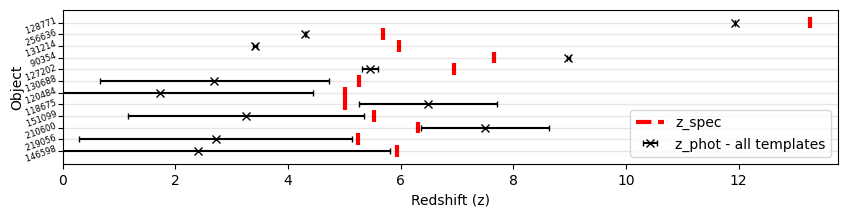

In [ ]:
##################### NOTING WORST POINTS #####################
#TODO: find the overall worst points across catalogues, note their average z_spec and z_phot, and sigma_phot

redshiftPoints = np.sum([photZs['output_df'][ftempl_strs[i]]['z_phot'] for i in range(len(ftempl_strs))],axis=0) / len(ftempl_strs)
redshiftPointsSpec = np.sum([photZs['output_df'][ftempl_strs[i]]['z_spec'] for i in range(len(ftempl_strs))],axis=0) / len(ftempl_strs)
redshiftPointsErr = np.std([photZs['output_df'][ftempl_strs[i]]['z_phot'] for i in range(len(ftempl_strs))],axis=0)
redshiftPointsDelta = np.abs(redshiftPoints - redshiftPointsSpec)
redshiftPointsIDs = photZs['output_df'][ftempl_strs[0]]['ID']

#sort by delta
sortIdx = np.argsort(redshiftPointsDelta/redshiftPointsErr)[::-1]
redshiftPoints = redshiftPoints[sortIdx]
redshiftPointsSpec = redshiftPointsSpec[sortIdx]
redshiftPointsErr = redshiftPointsErr[sortIdx]
redshiftPointsDelta = redshiftPointsDelta[sortIdx]
redshiftPointsIDs = redshiftPointsIDs[sortIdx]

#print first 10
idsOfInterest = []
print("Worst 10 points:")
fig, ax = plt.subplots(figsize=(10,2))
c=0
maxZSpec = 0
yTicks = []
for i in range(150):
    delta = redshiftPointsDelta[i]
    sigma_phot = redshiftPointsErr[i]
    z_spec = redshiftPointsSpec[i]
    z_phot = redshiftPoints[i]
    id = redshiftPointsIDs[i]
    if delta-sigma_phot < 0.0: continue
    if z_spec < 0.0: continue
    if z_phot < 0.0: continue
    if delta < 1: continue
    #if z_spec < 4.0: continue
    print(f"z_spec: {z_spec:.3f}, z_phot: {z_phot:.3f}, delta: {delta:.3f}, id: {id}, sigma_phot: {sigma_phot:.3f}")
    
    label = None
    if c == 0: label = "z_phot - all templates"
    plt.errorbar(z_phot, -c, xerr=sigma_phot, fmt='x', color='k', capsize=2, label=label)
    label = None
    if c == 0: label = "z_spec"
    plt.plot([z_spec,z_spec],[-c-0.5,-c+0.5],color='r',linestyle='--',label=label,linewidth=3)
    if z_spec > maxZSpec: maxZSpec = z_spec
    plt.plot([0,100],[-c,-c],color='k',linestyle='-',linewidth=1,alpha=0.1)

    yTicks.append(id)

    if sigma_phot < 0.5: 
        idsOfInterest.append(id)
        print("Added to list of interest")
    c+=1

#set y ticks to c locations
ax.set_yticks(-np.arange(len(yTicks)))
#remove numbers on yticks
ax.set_yticklabels([])
#annotate with IDs on yticks
for i,id in enumerate(yTicks):
    ax.annotate(str(id) + "  ", xy=(0, -i+0.7), xycoords='data', fontsize=6, ha='right', va='top',rotation=20)

plt.xlim(0,maxZSpec+0.5)
plt.xlabel("Redshift (z)")
plt.ylabel("Object")
ax.yaxis.set_label_coords(-0.05,0.5)
plt.legend()
plt.show()




In [ ]:
##################### PLOT REDSHIFT OUTPUT #####################
#TODO: needs tiling color by accumulative flux
mosTiling = 4
zMax = 16.5
mm = 1/25.4
figwidth = 183*mm
DPI = 500
zCharacteristic = 5

for mode in ['default', 'modified']:
    mode_ftempl_lbls = copy(ftempl_labels)
    mode_ftempl_strs = copy(ftempl_strs)
    if mode == 'modified': 
        mode_ftempl_lbls = [s for s in mode_ftempl_lbls if ";" in s]
        mode_ftempl_strs = [s for s in mode_ftempl_strs if ";" in s]
    if mode == 'default': 
        mode_ftempl_lbls = [s for s in mode_ftempl_lbls if ";" not in s]
        mode_ftempl_strs = [s for s in mode_ftempl_strs if ";" not in s]

    
    mosaicLen = ceil(len(mode_ftempl_lbls)/mosTiling)
    
    figsize = (1*figwidth,1*figwidth/mosTiling*mosaicLen)
    tiling = (mosaicLen,mosTiling)
    if len(mode_ftempl_lbls) < mosTiling:
        figsize = (1*figwidth/mosTiling*len(mode_ftempl_lbls),1*figwidth/mosTiling)
        tiling = (1,len(mode_ftempl_lbls))

    figMos, axsMos = plt.subplots(*tiling, figsize=figsize, dpi=DPI, facecolor=(1,1,1,0))
    #transpose and flatten
    if len(mode_ftempl_lbls) > 1:
        #axsMos = axsMos.T
        axsMos = axsMos.flatten()
    else:
        axsMos = [axsMos]
    plt.subplots_adjust(wspace=0, hspace=0)
    for i, ftempl in enumerate(mode_ftempl_strs):
        if ftempl not in photZs['output_df'].keys():
            continue
        redshiftTbl = photZs['output_df'][ftempl]
        redChar = {
            'z_spec': np.array(redshiftTbl['z_spec']),
            'z_phot': np.array(redshiftTbl['z_phot']),
        }
        mask = (redChar['z_spec'] > zCharacteristic) & (~np.isnan(redChar['z_spec'])) & (~np.isnan(redChar['z_phot']) & (redChar['z_phot'] > 0))
        redChar['z_spec'] = redChar['z_spec'][mask]
        redChar['z_phot'] = redChar['z_phot'][mask]
        deltaZ = (redChar['z_phot'] - redChar['z_spec'])/(1 + redChar['z_spec'])
        deltaZ_all = (redshiftTbl['z_phot'] - redshiftTbl['z_spec'])/(1 + redshiftTbl['z_spec'])
        outliers = (deltaZ > 0.15) | (deltaZ < -0.15)
        outliers_all = (deltaZ_all > 0.15) | (deltaZ_all < -0.15)
        bias = np.mean(deltaZ)
        scatter = np.std(deltaZ)


        #outpath = outpaths.format(ftempl=ftempl, runTime=runTime)

        """#find light intensities
        ids = df_props['id'].values
        filtTab = Table.read(inpath, hdu=4)
        #get values ending with "CIRC1"
        pointIDs = filtTab['ID']
        filtTab = filtTab[[f for f in filtTab.colnames if f.endswith('CIRC1')]]
        #get dictionary version of table
        filtTab = filtTab.to_pandas()
        keys = filtTab.keys()
        fluxes = np.array([np.array(filtTab[key]) for key in keys]).T
        pointIntensities = np.sum(fluxes, axis=1)"""

        """#clear up bad ids and make simular sort
        for j,id in list(enumerate(ids))[::-1]:
            if id not in df_props['id'].values:
                pointIntensities = np.delete(pointIntensities, j)
                ids = np.delete(ids, j)
        #sort pointIntensities and ids to match df_props
        pointIntensities = pointIntensities[np.argsort(ids)]
        ids = np.sort(ids)
        antiSort = np.argsort(df_props['id'].values)
        sort = np.argsort(antiSort)
        pointIntensities = pointIntensities[sort]
        ids = ids[sort]"""
        #Remove sub zero and nan
        mask_cur = (redshiftTbl['z_spec'] > 0) & (~np.isnan(redshiftTbl['z_spec'])) & (~np.isnan(redshiftTbl['z_phot'])) & (redshiftTbl['z_phot'] > 0)
        x = np.array(redshiftTbl['z_spec'])
        y = np.array(redshiftTbl['z_phot'])
        #above = y > x + (1 + x) * 0.15 # outliers
        #below = y < x - (1 + x) * 0.15
        #outlier = above | below
        #mask_in = mask_cur & (~outlier)
        x = x[mask_cur]
        y = y[mask_cur]
        #mask_out = mask_cur & outlier
        #chi2_fit = redshiftTbl['z_phot_chi2'][mask_cur]/len(redshiftTbl.keys())#!new
        #avgchi2_fit = np.mean(chi2_fit)
        #medchi2_fit = np.median(chi2_fit)
        
        #avgchi2_fit_in = redshiftTbl['z_phot_chi2'][mask_in]/len(x)#!new
        #c = np.log10(pointIntensities[mask_cur])*((x/(1+x))**2)#!quilitative reshift scaling
        #c = np.ones(len(x))

        #calculate chi2 with linear regression of x and y
        chi2 = np.sum((y - x)**2/1)/len(x)#/len(x)#!dunno what to put for sigma

        xmin, xmax = np.c_[[x, y]].min(), np.c_[[x, y]].max()

        #axsMos[i].scatter(x, y, s=2.0, color='k')
        #hexbin with colorbar
        #axsMos[i].hexbin(x, y, gridsize=30, mincnt=1, edgecolors='none', bins='log')
        underCharc = (x < zCharacteristic)
        axsMos[i].hexbin(x[underCharc], y[underCharc], gridsize=30, mincnt=1, edgecolors='none', bins='log', cmap='viridis', alpha=0.2, extent=[xmin, xmax, xmin, xmax])#TODO: choose cmap to something that doesn't blend in with the background
        axsMos[i].hexbin(redChar['z_spec'], redChar['z_phot'], gridsize=30, mincnt=1, edgecolors='none', bins='log', cmap='viridis', extent=[xmin, xmax, xmin, xmax])

        #plt.colorbar(axsMos[i].collections[0], ax=axsMos[i], label='log$_{10}$(N)')
        axsMos[i].plot([0, 100], [0, 100], c='r', ls='--', lw=0.5)
        axsMos[i].plot([zCharacteristic, zCharacteristic], [0, 14.5], c='r', ls='--', lw=0.5)
        
        #dict_stat = hmod.phot_spec_zs_stats(y, x)

        #annotate in top left
        annotAnchor = (0.05, 0.95)
        #axsMos[i].set_title(f'{ftempl}', fontsize=10)
        ax, ay = 2, 95        
        axsMos[i].annotate(f'{mode_ftempl_lbls[i]}', xy=annotAnchor, xycoords='axes fraction', fontsize=10, ha='left', va='top', xytext=(ax, ay), textcoords='axes points')

        #stats annotate
        sx, sy = 44, -55
        axsMos[i].annotate(f'$\eta$={round(outliers.sum()/len(outliers),3):.3f}', xy=annotAnchor, xycoords='axes fraction', fontsize=8, ha='left', va='top', xytext=(ax+sx, ay+sy), textcoords='axes points')
        if mode_ftempl_lbls[i] == 'F45k' or mode_ftempl_lbls[i] == 'F60k': asterix = '*'
        else: asterix = ''
        #axsMos[i].annotate(f'$\eta_{{0+}}$={round(outliers_all.sum()/len(outliers_all),2):.2f}{asterix}', xy=annotAnchor, xycoords='axes fraction', fontsize=8, ha='left', va='top', xytext=(ax+sx, ay+sy-10), textcoords='axes points')
        axsMos[i].annotate(f'$\sigma_{{nmad}}$={round(np.median(np.abs(deltaZ[~outliers] - np.median(deltaZ[~outliers])))*1.4826,4):.4f}', xy=annotAnchor, xycoords='axes fraction', fontsize=8, ha='left', va='top', xytext=(ax+sx, ay+sy-10), textcoords='axes points')
        axsMos[i].annotate(f'$\Delta_{{bias}}$={round(bias,3):.3f}', xy=annotAnchor, xycoords='axes fraction', fontsize=8, ha='left', va='top', xytext=(ax+sx, ay+sy-20), textcoords='axes points')


        axsMos[i].set_xlim(zmin,zMax)
        axsMos[i].set_ylim(0,zMax)

        axsMos[i].xaxis.set_minor_locator(MultipleLocator(1))
        axsMos[i].yaxis.set_minor_locator(MultipleLocator(1))
        axsMos[i].xaxis.set_major_locator(MultipleLocator(4))
        axsMos[i].yaxis.set_major_locator(MultipleLocator(4))

        if i % mosTiling != 0: axsMos[i].set_yticklabels([])
        else: axsMos[i].set_ylabel('$z_{phot}$', fontsize=10)
        if i < len(mode_ftempl_lbls)-mosTiling: axsMos[i].set_xticklabels([])
        else: axsMos[i].set_xlabel('$z_{spec}$', fontsize=10)

    for i in range(len(axsMos)):
        if i > len(mode_ftempl_lbls)-1:
            axsMos[i].axis('off')

    """if len(ftempl_strs) % 3 != 0:
        axsMos[-1].axis('off')
    if len(ftempl_strs) % 3 == 1:
        axsMos[-2].axis('off')"""

    #axis label
    #figMos.text(0.5, 0.05, '$z_{spec}$', ha='center', va='center')
    #figMos.text(0.05, 0.5, '$z_{phot}$', ha='center', va='center', rotation='vertical')

    figMos.savefig(f'./figures/zs_mosaic_{mode}.png', dpi=DPI, bbox_inches='tight', transparent=True)
    figMos.clf()
    plt.close(figMos)
    #show by loading image
    img = plt.imread(f'./figures/zs_mosaic_{mode}.png')
    fig = plt.figure(figsize=(1*figwidth,1*figwidth/mosTiling*mosaicLen), dpi=200, facecolor=(1,1,1,0))
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    ax.imshow(img)


NameError: name 'copy' is not defined

In [ ]:
##################### REMOVE ALL OBJECTS UNDER CHARACTERISTIC REDSHIFT #####################
#from now on, we only want a comparison of objects above the characteristic redshift, so we remove all objects below
zcut = zCharacteristic
for templ in ftempl_strs:
    z_spec = photZs['input_df'][templ]['z_spec'].values
    mask = (z_spec > zcut) & (~np.isnan(z_spec))
    photZs['input_df'][templ] = photZs['input_df'][templ][mask]
    photZs['output_df'][templ] = photZs['output_df'][templ][mask]
    


In [ ]:
##################### REDSHIFT PERFORMANCE METRICS #####################
#TODO: create a pandas dataframe over bias, scatter, so on
#TODO: both print it out here and make a latex table for the paper

fsps_45k;0.3removed
Chi2: 46.77 ID: 197088
Chi2: 129.18 ID: 132780
Chi2: 282.89 ID: 101990
Chi2: 549.39 ID: 114213
Chi2: 2878.94 ID: 197348
corr_sfhz_13
Chi2: 48.42 ID: 210625
Chi2: 117.72 ID: 131971
Chi2: 231.41 ID: 130262
Chi2: 358.07 ID: 114213
Chi2: 610.87 ID: 131688


/tmp/ipykernel_2192/1947238200.py:149: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  fig.clf()


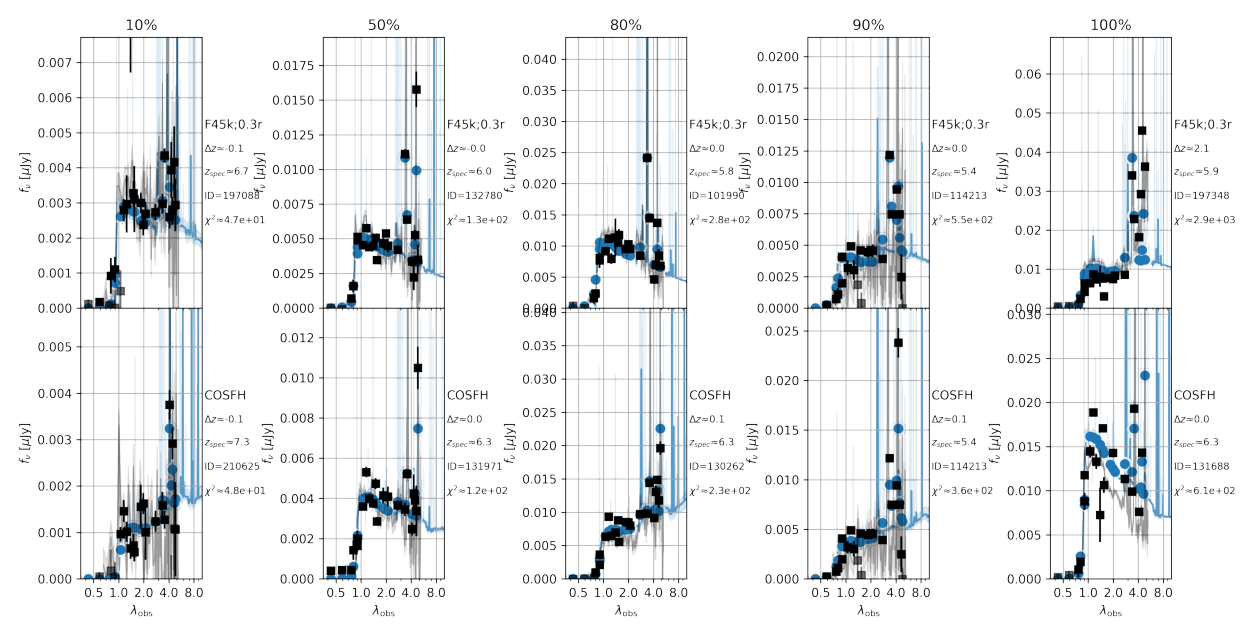

In [ ]:
##################### PLOT RESTFRAME SEDS #####################
#fig, axss = plt.subplots(len(ftempl_strs), 2, figsize=(16, 4*len(ftempl_strs)), dpi=300, width_ratios=[2, 1])
includeChi2s = [0.1,0.5,0.8,0.9,1]
fig, axss = plt.subplots(len(ftempl_strs), len(includeChi2s), figsize=(16, 4*len(ftempl_strs)), dpi=300, sharex=True)
if len(axss.shape) == 1:
    axss = np.array([axss])
#set vertical spacing =0
plt.subplots_adjust(hspace=0, wspace=0.25*(len(includeChi2s)-1))

for i, df_in, pz_in, df_out, pz_out, ftempl in zip(range(len(ftempl_strs)), photZs['input_df'].values(), photZs['input_pz'].values(), photZs['output_df'].values(), photZs['output_pz'].values(), ftempl_strs):
    print(ftempl)
    chi2s = df_out['z_phot_chi2']
    chi2s = [chi2 if chi2 > 0 else 0 for chi2 in chi2s]
    chi2s = [chi2 if df_out['z_spec'][i] > 0 else 0 for i, chi2 in enumerate(chi2s)]
    ids = df_out['ID']
    chi2s = [chi2 if id in photZs['specs'].keys() else 0 for id, chi2 in zip(ids, chi2s)]
    sort = list(np.argsort(chi2s))[chi2s.count(0):]
    #remove if chi2 < 0:
    include = [int(inc*(len(sort)-1)) for inc in includeChi2s]
    sort = np.array(sort)[include]
    del include

    IDs, chi2s = df_out['ID'][sort], np.array(chi2s)[sort]

    for j, chi2, id_cat in zip(range(len(sort)), chi2s, IDs):
        print(f"Chi2: {chi2:.2f} ID: {id_cat}")
        

        #chi2s = chi2s[sort]
        
        #axs = axss[i]
        #axs = axs.flatten()
        z_phot = df_out['z_phot'][df_out['ID'] == id_cat][0]
        z_spec = df_out['z_spec'][df_out['ID'] == id_cat][0]
        
        pz_out.show_fit(
            id=id_cat, add_label=False, axes=[axss[i][j]],#TODO: add labels, but change config so that legend is nicer
            #show_components=True,
            zshow=z_spec,#!best guess
            xlim=[0.35, 10.0], 
            
            show_missing=True,#!these are the hexagons
            show_stars=False, snr_thresh=1.0,
            show_fnu=True,
            with_tef=True,
            #template_color='#1f77b4',
            alpha_multiplier = 1.4,
            )
        if i != len(ftempl_strs)-1: axss[i][j].set_xlabel('')
        #!plot actuall guess
        #TODO: fix
        data = pz_out.show_fit(id=id_cat, zshow=z_phot, get_spec=True, show_fnu=True)
        tempspec_zphot = [data['templz']*u.AA, data['templf']*u.uJy]
        axss[i][j].plot(tempspec_zphot[0], tempspec_zphot[1], c='r', lw=0.5, ls='--')#!set units correct so that plot is visible
        if i == 0: axss[i][j].set_title(f'{includeChi2s[j]*100:.0f}%')
        #set y max lim to 1.5 times higher
        axss[i][j].set_ylim(0, axss[i][j].get_ylim()[1]*1.5)
        
        
        #annotate to the right of the frame; chi2, objid, redshift, delta_z
        anXs = [1.02]*5
        anYs = np.linspace(0.0, len(anXs)*0.07, len(anXs))+(0.5-(len(anXs)*0.07/2))
        axss[i][j].annotate(f'{ftempl_labels[i]}', xy=(anXs[4],anYs[4]), xycoords='axes fraction', fontsize=10, ha='left', va='center', textcoords='offset points', xytext=(0,0))#TODO: move to left
        axss[i][j].annotate(f'$\chi^2$≈{"{:.1e}".format(chi2)}', xy=(anXs[0],anYs[0]), xycoords='axes fraction', fontsize=8, ha='left', va='center', textcoords='offset points', xytext=(0,0))
        axss[i][j].annotate(f'ID={id_cat}', xy=(anXs[1],anYs[1]), xycoords='axes fraction', fontsize=8, ha='left', va='center', textcoords='offset points', xytext=(0,0))
        axss[i][j].annotate(f'$z_{{spec}}$≈{z_spec:.1f}', xy=(anXs[2],anYs[2]), xycoords='axes fraction', fontsize=8, ha='left', va='center', textcoords='offset points', xytext=(0,0))
        axss[i][j].annotate(f'$\Delta z$≈{z_phot-z_spec:.1f}', xy=(anXs[3],anYs[3]), xycoords='axes fraction', fontsize=8, ha='left', va='center', textcoords='offset points', xytext=(0,0))

        #plot spec data
        spec_data = photZs['specs'][id_cat]
        axss[i][j].plot(spec_data['wave'], spec_data['flux'], c='k', lw=1, ls='-', alpha=0.3)
        axss[i][j].fill_between(spec_data['wave'], spec_data['flux']-spec_data['flux_err'], spec_data['flux']+spec_data['flux_err'], color='k', alpha=0.1)

        #rebin model spectra to simular wavelength intervals
        intervals = np.array([spec_data['wave'][k+1] - spec_data['wave'][k] for k in range(len(spec_data['wave'])-1)])
        meanInterval = np.mean(intervals)
        targetWave = copy(spec_data['wave'])

        x_fit = axss[i][j].lines[3].get_xdata()#where best fit template is stored
        y_fit = axss[i][j].lines[3].get_ydata()
        try:
            x_fit = x_fit.to(u.AA).value
            y_fit = y_fit.to(u.uJy).value
            print("Found odd unit thing:P")
        except:
            pass
        x_fill = axss[i][j].collections[5].get_paths()[0].vertices[:,0]#where best fit template error is stored
        y_fill = axss[i][j].collections[5].get_paths()[0].vertices[:,1]
        indMaxxfill = np.where(x_fill == x_fill.max())[0][0]
        x_fill_bot = x_fill[:indMaxxfill]
        y_fill_bot = y_fill[:indMaxxfill]
        x_fill_top = x_fill[indMaxxfill:]
        y_fill_top = y_fill[indMaxxfill:]
        xMax = axss[i][j].get_xlim()[1]
        xMin = axss[i][j].get_xlim()[0]
        topSort = np.argsort(x_fill_top)
        botSort = np.argsort(x_fill_bot)
        x_fill_top = x_fill_top[topSort]
        y_fill_top = y_fill_top[topSort]
        x_fill_bot = x_fill_bot[botSort]
        y_fill_bot = y_fill_bot[botSort]
        """plt.plot(x_fill_top, y_fill_top)
        plt.plot(x_fill_bot, y_fill_bot)
        plt.xlim(xMin, xMax)
        plt.ylim(*axss[i][j].get_ylim())
        plt.show()"""

        #rebin to target intervals
        targetFlux = np.interp(targetWave, x_fit, y_fit)#!ERRROR: interpolation is not correct
        targetFlux_yfill_top = np.interp(targetWave, x_fill_top, y_fill_top)#!not correct interpolation method for errorbars...
        targetFlux_yfill_bot = np.interp(targetWave, x_fill_bot, y_fill_bot)
        """plt.plot(targetWave, targetFlux_yfill_top)
        plt.plot(targetWave, targetFlux_yfill_bot)
        plt.show()"""

        addWave = targetWave[-1] + meanInterval
        while addWave < x_fit[-1] and addWave < xMax:
            targetWave = np.append(targetWave, addWave)
            targetFlux = np.append(targetFlux, np.interp(addWave, x_fit, y_fit))
            targetFlux_yfill_top = np.append(targetFlux_yfill_top, np.interp(addWave, x_fill_top, y_fill_top))
            targetFlux_yfill_bot = np.append(targetFlux_yfill_bot, np.interp(addWave, x_fill_bot, y_fill_bot))
            addWave += meanInterval
        addWave = targetWave[0] - meanInterval
        while addWave > x_fit[0] and addWave > xMin:
            targetWave = np.insert(targetWave, 0, addWave)
            targetFlux = np.insert(targetFlux, 0, np.interp(addWave, x_fit, y_fit))
            targetFlux_yfill_top = np.insert(targetFlux_yfill_top, 0, np.interp(addWave, x_fill_top, y_fill_top))
            targetFlux_yfill_bot = np.insert(targetFlux_yfill_bot, 0, np.interp(addWave, x_fill_bot, y_fill_bot))
            addWave -= meanInterval
        """plt.plot(targetWave, targetFlux_yfill_top)
        plt.plot(targetWave, targetFlux_yfill_bot)
        plt.show()"""
        #stitch errorverticies together again
        targetFlux_xfill = np.append(targetWave, targetWave[::-1])
        targetFlux_yfill = np.append(targetFlux_yfill_bot, targetFlux_yfill_top[::-1])

        axss[i][j].lines[3].set_xdata(targetWave)
        axss[i][j].lines[3].set_ydata(targetFlux)
        axss[i][j].collections[5]._paths[0].verticies = np.array([targetFlux_xfill, targetFlux_yfill]).T
        
        #set new collors
        #axss[i][j].lines[3].set_color(
        
        pass
        


fig.savefig(f'./figures/seds.png', dpi=300, bbox_inches='tight', transparent=True)
fig.clf()
plt.close(fig)
#show by loading image
img = plt.imread(f'./figures/seds.png')
fig = plt.figure(figsize=(16, 4*len(ftempl_strs)), dpi=100, facecolor=(1,1,1,0))
plt.axis('off')
plt.imshow(img)